# Import libraries 

Importing all the libraries that are used. Some might not be needed by this notebook, but are there for debugging purposes. I hope to create a separate python file just for import statements to avoid importing these in every notebook.

In [1]:
import pandas as pd
import numpy as np
from itertools import cycle
import time

import sklearn
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
from scipy import interp
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib inline
matplotlib.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

## Import the custom helper files

In [2]:
from algorithm_helpers import *
from visualisation_helpers import *

# Load and prepare the data

I'll be using the ```vehicles.csv``` dataset. We load it using pandas.

In [3]:
path = '../../datasets/vehicles.csv'  # Path to dataset
df = pd.read_csv(path)

In [4]:
X = df.drop(labels='Class', axis=1)  # Drop the target attribute from the X variable
# We are not normalising the data for this particular notebook.
y = df.Class  # The target attribute to be predicted

# Cross validation performance analysis: a high level exploration

We would be comparing the accuracies of Shuffle split and K-fold cross validation techniques as well as their stratified versions. Thus, to enumerate, our exploration would be based on:
* Shuffle split
* K-fold split
* Stratified shuffle split
* Stratified k-fold split.

We keep the ```test_size``` of the shuffle split variations such that it matches the fold size of the k-fold variations for a given number of splits/folds.

In [5]:
# We create a dictionary for each type of cross-validation technique with the keys as the number of splits
# and the values being the corresponding objects.
cv_shuffle_split = {}
cv_kfold_split = {}
cv_stratified_shuffle_split = {}
cv_stratified_kfold_split = {}
# We vary the number of splits as 10, 20, 30..., 90 for each cross-validator
for i in range (5, 100, 5):
    test_ratio = i / 100
    cv_shuffle_split[i] = model_selection.ShuffleSplit(n_splits = i, test_size = test_ratio, train_size = 1 - test_ratio, random_state = 42)
    cv_kfold_split[i] = model_selection.KFold(n_splits = i, shuffle=True, random_state = 42)
    cv_stratified_shuffle_split[i] = model_selection.StratifiedShuffleSplit(n_splits = i, test_size = test_ratio, train_size = 1 - test_ratio, random_state = 42)
    cv_stratified_kfold_split[i] = model_selection.StratifiedKFold(n_splits = i, shuffle=True, random_state = 42)

Only 3 classifiers are used to reduce unnecessary complexity. However, the classifiers used are all of different types.

In [6]:
MLA = [
        ensemble.RandomForestClassifier(criterion='entropy', max_depth=14, n_estimators=1000, oob_score=True),

        svm.SVC(C=4, gamma=0.1),
    
        discriminant_analysis.QuadraticDiscriminantAnalysis(),
        ]

**Normalization?** Random forest and QDA do not require normalization but support vector machine does in most cases. Normalization is peformed using a pipeline and a standard scaler later when we run the model. However, I had also tried running it without normalization as I found the idea of keeping an imperfect classifier (SVC) interesting. But it did not give any interesting results so I ultimately discarded the idea and went with normalization.

Let's view the classifier hyper-parameters (we are using the defaults ones though).

In [7]:
for clf in MLA:
    print(clf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)
SVC(C=4, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)


```get_cv_comparision()``` takes in the classifiers, input data, labels and cross-validation technique as input and returns a pandas *DataFrame* object with the representation:
* Columns: Mean test accuracy with each classifier used
* Rows: Each split used (10, 20, 30..., 90).

To be honest, this took a lot of time to write, especially arranging it properly into a dictionary and then converting the list of dictionaries into a pandas dataframe. Anyway, it now works as I wanted it to :D

In [8]:
def get_cv_comparison(MLA, X, y, train_X, train_y, test_X, cv):
    MLA_compare = pd.DataFrame()
    MLA_list = []
    for n_split, cv_split in cv.items():
        MLA_com, _ = run_models(MLA, X, y, train_X, train_y, test_X, cv_split)
        MLA_com.drop(['MLA Parameters', 'MLA Test Accuracy 3*STD', 'MLA Train Accuracy Mean', 'MLA Time'],
                     axis=1, inplace=True)

        MLA_dict = MLA_com.set_index('MLA Name').T.to_dict('list')
        for i, value in MLA_dict.items():
            MLA_dict[i] = value[0]  # Unpack the one-d array
        MLA_dict['n_splits'] = n_split
        MLA_list.append(MLA_dict)
    return pd.DataFrame(MLA_list).set_index('n_splits')

Now we proceed to obtain the split-wise comparison tables for each of the 4 cross-validation techniques used.

Note: This takes a while to run.

In [9]:
train_X, test_X, train_y, test_y = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
%%time
cv_shuffle_comp = get_cv_comparison(MLA, X, y, train_X, train_y, test_X, cv_shuffle_split)
cv_kfold_comp = get_cv_comparison(MLA, X, y, train_X, train_y, test_X, cv_kfold_split)
cv_stratified_shuffle_comp = get_cv_comparison(MLA, X, y, train_X, train_y, test_X, cv_stratified_shuffle_split)
cv_stratified_kfold_comp = get_cv_comparison(MLA, X, y, train_X, train_y, test_X, cv_stratified_kfold_split)

CPU times: user 2min 24s, sys: 1.2 s, total: 2min 25s
Wall time: 13min 27s


## Shuffle split vs k-fold

Shuffle split takes the dataset and picks a number of samples according to the test and train sizes specified in a **random** order. Since this works like a generator, subsequently calling it will yield the subsequent batches of samples till the number of splits is exceeded. However, shuffle split picks random samples on each call and does not guarantee that the samples returned would be unique with respect to the previous batch returned, which also means that unless the number of splits is large the entire dataset might not be used.

K-fold, on the other hand, also being a generator, randomly shuffles the dataset but just **once** and returns batches consecutively with no overlap of **test** samples. This guarantees unique **test** samples in each batch. The train set (size is automatically computed with the number of splits given), however, is taken as the complementary of the test set, meaning that there will be overlap between batches.

Stratification refers to splitting the dataset in such a way that ideally the **proportion** of each class in each train and test set returned is same. For the dataset we are using, the classes are mostly balanced, hence stratification would not be beneficial to that effect.

The **metric** we have used for comparison is **mean test accuracy** for each classifier.

## Shuffle split

Note: The values in the table are the **mean test accuracy** for the respective classifiers.

In [11]:
cv_shuffle_comp

,QuadraticDiscriminantAnalysis,RandomForestClassifier,SVC
n_splits,,,
5,0.860465,0.809302,0.800000
10,0.850588,0.741176,0.791765
15,0.850394,0.762205,0.807349
20,0.858529,0.761765,0.810000
25,0.855472,0.760566,0.810755
30,0.850262,0.757874,0.798031
35,0.846946,0.754305,0.791631
40,0.845059,0.751032,0.785914
45,0.841062,0.748556,0.782152


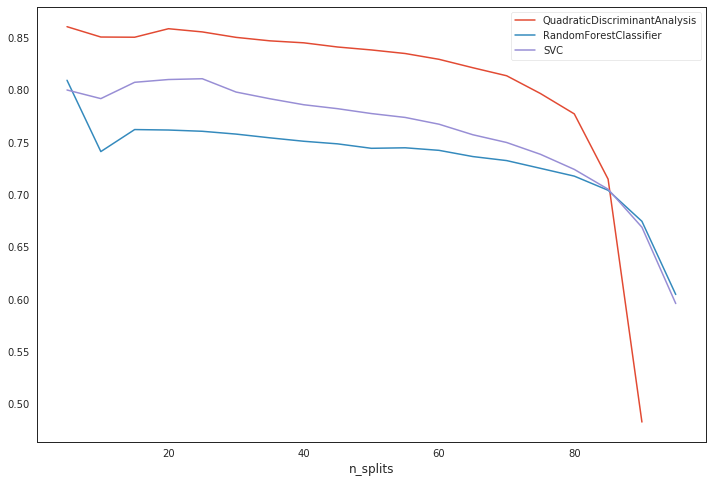

In [12]:
cv_shuffle_comp.plot.line(legend=True)  # The legend can be turned off to get a clearer view of the top-right corner

In all the classifiers, we observe a drop from 5 splits followed by an increase till 20 splits, after which they start decreasing at a constant rate until 80 splits, after which there is a sharper fall.

The fall after 80 splits is because the test size is only 10 datapoints per split and training on the remaining ~830 samples might overfit the model. Now, it is also to be noted that overfitting should not affect the performance to a very high extent as the mean accuracy is actually the mean of 80 different splits. However, in shuffle split, samples are picked up up randomly and pushed to the training or test sets, which does not guarantee 80 unique splits and hence the mean accuracy does not represent the complete picture. **This is why shuffle split is not recommended for small datasets**.

For QDA in particular, the mean accuracy falls very sharply with a small test size because it performs feature analysis and classifies according to the most important features. Now, averaging it out on 80 splits wouldn't have been a problem but since unique splits are not guaranteed, the amount of bias entering the system is significant.

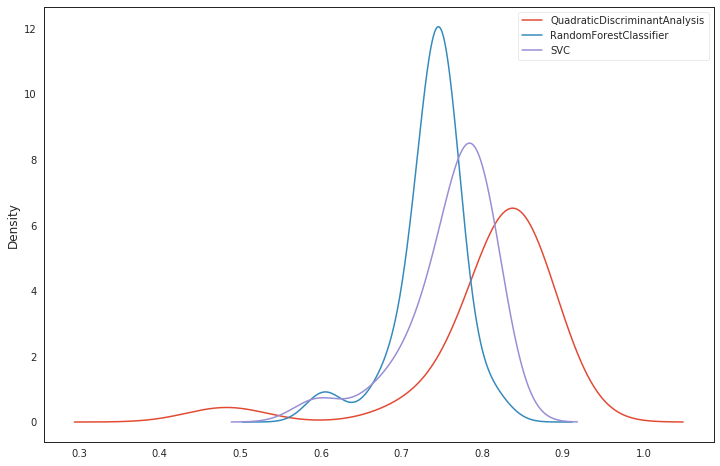

In [13]:
cv_shuffle_comp.plot.kde()

All classifiers have a large spread, but the spread of RF is somewhat less because it employs ensembling which can neutralize the bias due to a very large number of splits.

## K-fold split

In [14]:
cv_kfold_comp

,QuadraticDiscriminantAnalysis,SVC,RandomForestClassifier
n_splits,,,
5,0.847477,0.786042,0.742304
10,0.853333,0.804874,0.751597
15,0.853363,0.795426,0.748141
20,0.855676,0.803654,0.752852
25,0.855615,0.804920,0.751551
30,0.861576,0.807307,0.751683
35,0.858000,0.807238,0.755190
40,0.855628,0.806006,0.751569
45,0.856530,0.803379,0.746459


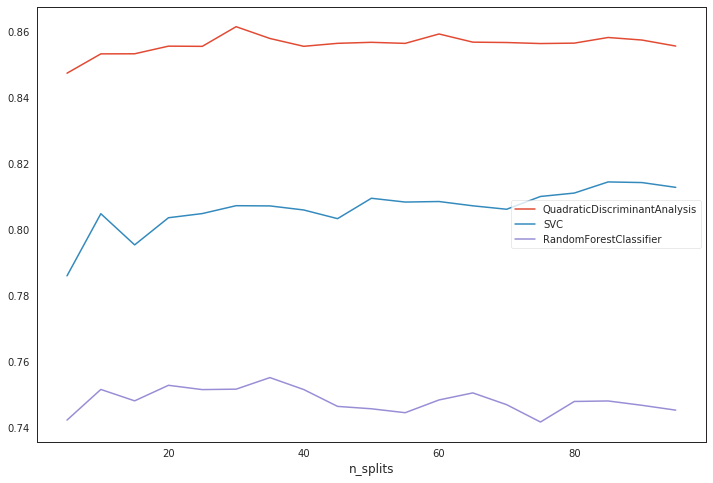

In [15]:
cv_kfold_comp.plot.line(legend=True)

K-fold, unlike shuffle split, ensures utilization of the entire dataset. Due to this, there is no drastic increase or drop in mean accuracy across folds.

The RF classifier, however, gives considerably better results for shuffle split when the number of splits is 5.

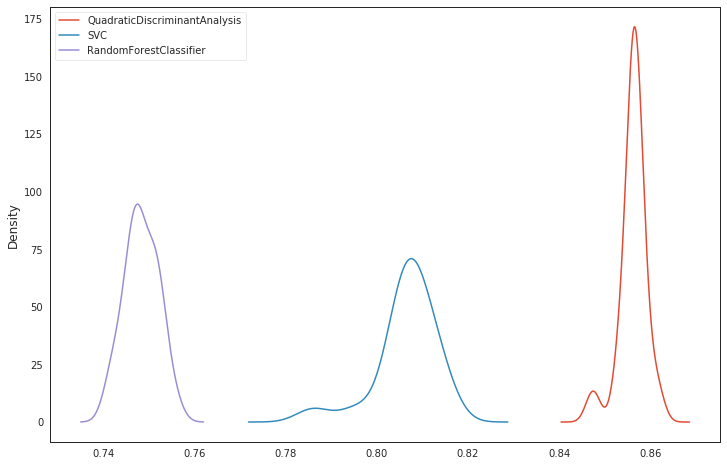

In [16]:
cv_kfold_comp.plot.kde()

As we can see, QDA is hardly affected by the number of folds, while SVC seems to have the highest variance.

## Stratified shuffle split

The stratified versions give more or less same results as the unstratified versions and that is because the dataset is already well-balanced.

In [17]:
cv_stratified_shuffle_comp

,QuadraticDiscriminantAnalysis,SVC,RandomForestClassifier
n_splits,,,
5,0.846512,0.786047,0.711628
10,0.828235,0.798824,0.731765
15,0.829396,0.795801,0.737008
20,0.840882,0.802941,0.749706
25,0.842075,0.800000,0.746415
30,0.850394,0.801706,0.749344
35,0.842039,0.796344,0.747860
40,0.843068,0.792183,0.747198
45,0.845669,0.790085,0.748906


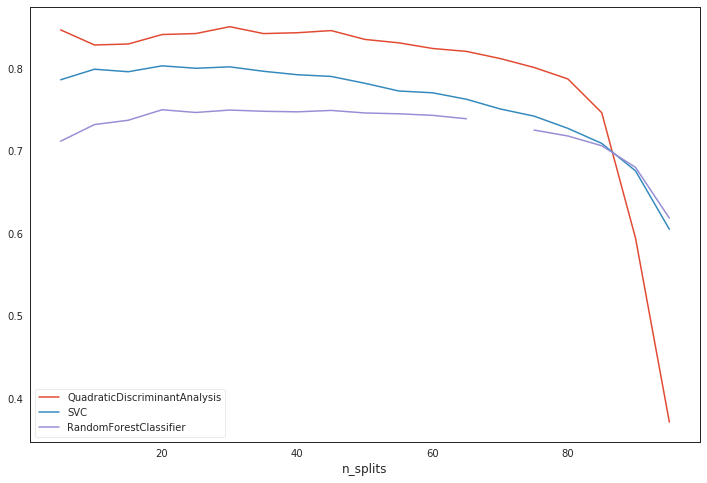

In [18]:
cv_stratified_shuffle_comp.plot.line(legend=True)

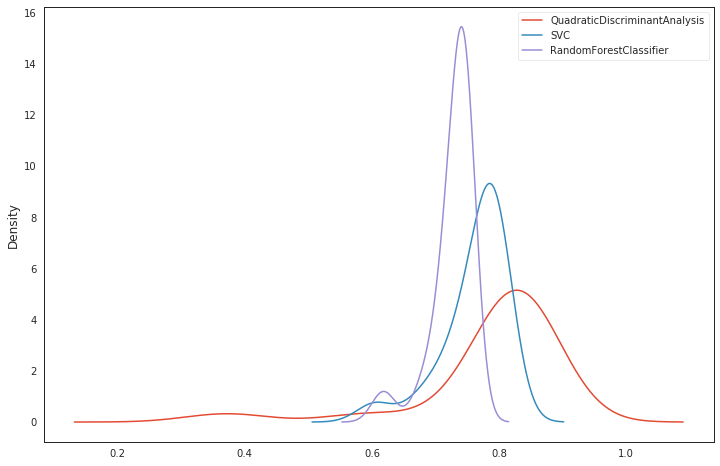

In [19]:
cv_stratified_shuffle_comp.plot.kde()

## Stratified k-fold split

In [20]:
cv_stratified_kfold_comp

,QuadraticDiscriminantAnalysis,SVC,RandomForestClassifier
n_splits,,,
5,0.838079,0.806105,0.751765
10,0.854636,0.802619,0.749440
15,0.847577,0.815560,0.755221
20,0.849889,0.800083,0.749252
25,0.851052,0.808556,0.756542
30,0.847496,0.804680,0.750452
35,0.851048,0.805857,0.752952
40,0.853571,0.810660,0.756602
45,0.852242,0.807342,0.751852


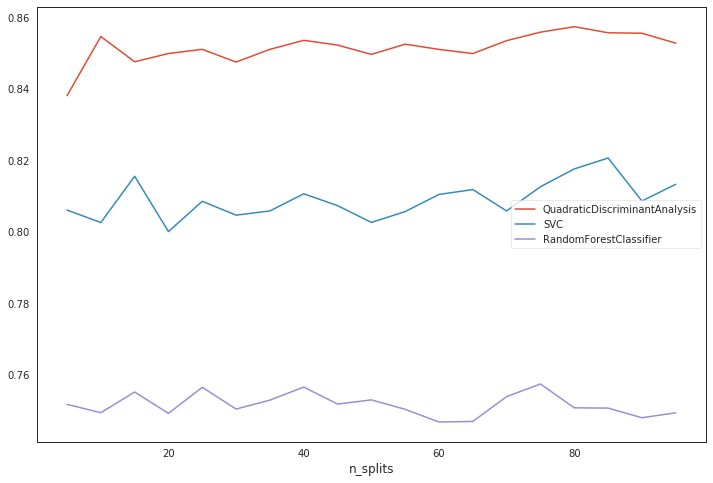

In [21]:
cv_stratified_kfold_comp.plot.line(legend=True)

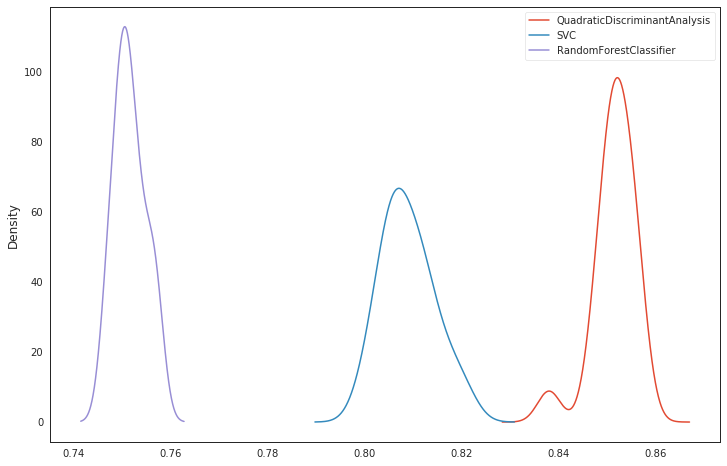

In [22]:
cv_stratified_kfold_comp.plot.kde()

The RF classifier has a very low variance while QDA is a close second.

## Inference

Our dataset is very small with only 846 samples while we have as many as 18 features. So with shuffle split, having a 80-20 train-test split is okay but with a smaller test ratio, performance starts to detoriorate as the classifiers do not generalize well due to the splits being randomly sampled with repetition. With k-fold, however, the performance remains stable for a large range of folds.

This brings us to a conclusion that for small datasets, k-fold is a better alternative to shuffle split. Moreover, for a balanced dataset, stratification does not help.

# Corner case analysis (leave-one-out CV)

Now we will see what happens with a test size of just one datapoint. The cross validation is k-fold so that we use test for each datapoint, the parameters do not really matter in this case because with just one test sample, the underlying operation will be the same.

In [51]:
%%time
extreme_split = model_selection.KFold(n_splits=len(y))
MLA_com, _ = run_models(MLA, X, y, train_X, train_y, test_X, extreme_split)
MLA_com

CPU times: user 3.84 s, sys: 119 ms, total: 3.95 s
Wall time: 2min 42s


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
2,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.915263,0.855792,1.053902,0.003977
1,SVC,"{'C': 4, 'break_ties': False, 'cache_size': 20...",0.929347,0.808511,1.180420,0.022859
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1.000000,0.744681,1.308121,2.741817


This actually gives a pretty good estimate of the results we have obtained so far, even the variance is not very high. A conclusion we can draw from this is that there are not too many outliers in the dataset.

# Source code analysis: a low level exploration

In this section I'll copy the most vital parts of the source codes of **shuffle split** and **k-fold** and analyse the internal working by splitting the code into several cells and printing the variables at each step.
This is done as a comparison between the approaches taken by shuffle split and k-fold, hence their stratified versions are not explored.

## K-fold

The k-fold split can be configured in the following manner:
```
model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
```
* n_splits: Number of smaller sub-datasets or folds that the dataset will be broken into
* shuffle: Whether to shuffle the data before splitting into folds
* random_state: Seed used by the random number generator, it is used to replicate the same run multiple times.

Internally, it has a function with the definition ```_iter_test_indices(self, X, y=None, groups=None)``` that returns (yields) the indices which would be used as test data for running the classifier while the remaining indices will be used as training data. Now, on subsequent calls to the function, the remaining folds are returned and the classifier is run as many times as the number of splits or folds. The mean accuracy is taken and the overall classifier becomes an ensemble of these similar classifiers which are trained on different sets and tested on different sets on an individual capacity.
Note: The argument *groups* is probably needed in GroupKFold, I did not see its use in the function body of ```_iter_test_indices()```.

Please uncomment the cell below to view the source code of the class *KFold*.

In [23]:
# ??model_selection.KFold

The following cells are just the body of the function ```_iter_test_indices()``` split up into several cells so that the internal flow can be understood clearly.

In [24]:
from sklearn.utils.validation import _num_samples
from sklearn.utils import check_random_state  # Mandatory import for using shuffle

We begin by setting the input arguments of the *KFold* constructor manually.

In [25]:
n_splits = 10
shuffle = True
random_state = 42

After that, we obtain the number of datapoints in X.

In [26]:
n_samples = _num_samples(X)
print(n_samples)

846


Having done that, we obtain an evenly spaced 1-d array listing all values from 0 till n_samples.

In [27]:
indices = np.arange(n_samples)
print(indices)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

If *shuffle* is True, all indices are shuffled according to the *random_state* seed, else, the *indices* array is kept as it was.

In [28]:
if shuffle:
    check_random_state(random_state).shuffle(indices)
print(indices)

[ 39 250 314  96 198 110 328 306 433 428 712 745 139 536 810 784 351 292
 833 215 541  86 439 772 209 342 425  30 754 254 355 436 669 227 732 731
 598 468 558 736 244 266 196 779 583 506 239 316 109 429 396 319  23 742
 218 280 409  67 806 766 733 514 192  78  66  63 552 323  65 359 422 494
 120 294 137 521 832 827  49 842 168 204 630 596 841  33  31 333 621 434
 623 500 464 299  72  77 838 537 398 501 361 764 426 420 368 275 625 762
 365 331 597 638 290   5  54 572 794 821 773 377  97 811  76 174 799 809
 286 477 710 823  84  10 691 247 738 118 697 260  29 212 781 525 676  81
 618 327 532 210 231 723 659 678 444 549 755 703 685   7 350 155 672 101
 801 530 332 792   2 760 778 311 665 633 570 788 539 673 259 543 660 483
 765  79 148 380 548 746 694 211 334 208 133 628 756 518  55 610 637 739
 591 713 582 693 382 479 412  60 199 604 603 213 576 481 559 615 658 302
 671 761  90 793 181 448 394 362 158  69 431 131  44 291  70 336 798 338
 450 135  82 165 164  28 442 193 265 547 417 136 54

Next, we calculate the size of each of the *n_splits* number of smaller datasets (or folds) that the entire dataset would be split into.

In [29]:
fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
print(fold_sizes)
print(sum(fold_sizes))
print(n_samples)

[84 84 84 84 84 84 84 84 84 84]
840
846


Equal splitting has caused some datapoints to be left out (6 in this case), so we accommodate them in the first 6 splits, increasing the size of each of the first 6 folds by 1.

In [30]:
fold_sizes[:n_samples % n_splits] += 1
print(fold_sizes)

[85 85 85 85 85 85 84 84 84 84]


In [31]:
# current stores 1 plus the the last index of the last fold returned (i.e., the beginning index of the current fold).
# However, it is initialized to 0 and is updated inside the for loop every time a fold is returned (or yielded).
current = 0
# The loop is supposed to iterate once each time the original function (of which this code snippet is a part)
# is called due to the yield statement inside (has been commented out in this snippet). 
for fold_size in fold_sizes:
    # The starting and ending indices of the current fold are computed.
    start, stop = current, current + fold_size
    
    # Originally, the code is part of a function and has a yield statement so that every time the function is called,
    # it can resume from the line succeeding the yield statement. However, since this is for demonstration purposes
    # and is not part of a function, I have commented out the yield statement and have written a print statement
    # instead to understand what it would have returned.
    
    # yield indices[start:stop]
    print(indices[start:stop], '\n')
    current = stop

[ 39 250 314  96 198 110 328 306 433 428 712 745 139 536 810 784 351 292
 833 215 541  86 439 772 209 342 425  30 754 254 355 436 669 227 732 731
 598 468 558 736 244 266 196 779 583 506 239 316 109 429 396 319  23 742
 218 280 409  67 806 766 733 514 192  78  66  63 552 323  65 359 422 494
 120 294 137 521 832 827  49 842 168 204 630 596 841] 

[ 33  31 333 621 434 623 500 464 299  72  77 838 537 398 501 361 764 426
 420 368 275 625 762 365 331 597 638 290   5  54 572 794 821 773 377  97
 811  76 174 799 809 286 477 710 823  84  10 691 247 738 118 697 260  29
 212 781 525 676  81 618 327 532 210 231 723 659 678 444 549 755 703 685
   7 350 155 672 101 801 530 332 792   2 760 778 311] 

[665 633 570 788 539 673 259 543 660 483 765  79 148 380 548 746 694 211
 334 208 133 628 756 518  55 610 637 739 591 713 582 693 382 479 412  60
 199 604 603 213 576 481 559 615 658 302 671 761  90 793 181 448 394 362
 158  69 431 131  44 291  70 336 798 338 450 135  82 165 164  28 442 193
 265 547 417

After the indices of the test set is obtained, the remaining datapoints are used for training the classifier. I am not going into that part of the source code because that is quite procedural and straightforward, not interesting to explore.

## Shuffle split

The shuffle split cross-validator can be configured in the following manner:
```
model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 42)
```
We notice that the train and test sizes can be configured separately (it is intentionally made 60-30 to show that).

Since shuffle split is just a normal train-test split spearately performed *n_split* number of times, we will do only an overview of the internal working.

Please uncomment the following cell to view the source code of shuffle split.

In [32]:
# ??model_selection.ShuffleSplit

In [33]:
from sklearn.model_selection._split import _validate_shuffle_split  # Used internally

In [34]:
n_splits = 10
test_size = 0.3
train_size = 0.6
random_state = 42
_default_test_size = 0.1  # Not used here but is originally used when train and test sizes are not provided

In [35]:
n_samples = _num_samples(X)
# _validate_shuffle_split() checks if the test/test sizes are meaningful wrt to the
# size of the data (n_samples)

n_train, n_test = _validate_shuffle_split(
    n_samples, test_size, train_size,
    default_test_size=_default_test_size)
print(n_train)
print(n_test)

507
254


In [36]:
rng = check_random_state(random_state)  # Create the random number generatpr with the given seed

In [37]:
for i in range(n_splits):
    permutation = rng.permutation(n_samples)  # Create a random partition
    ind_test = permutation[:n_test]  # Store indices of the test set
    ind_train = permutation[n_test:(n_test + n_train)]  # # Store indices of the training set
    # The yield statement is replaced with a print statement so that we can observe what is being yielded.
    
    # yield ind_train, ind_test
    
    # Only the size is printed to keep the output small.
    print(len(ind_train))
    print(len(ind_test))

507
254
507
254
507
254
507
254
507
254
507
254
507
254
507
254
507
254
507
254


The size matches the 60-30 split we intended to do. It is also evident from the source code that there is no specific effort directed towards creating unique test sets for each batch as random samples are taken for each set. Of course, that is what makes it different from k-fold.

# The previous version

In the previous version, I varied the number of splits but not the test size for shuffle split and had kept it fixed at 60-30. A conclusion I think would be good to add here is that the mean accuracy remained almost constant across all splits.